# Analyze Energy Ratios during Baseline Operation

In this notebook, we will demonstrate how to compute and plot the energy ratio between test and reference turbines as a function of wind direction. We'll focus on baseline operation for this example (i.e., without wake steering). The energy ratios can be used to evaluate wake losses experienced by different turbines.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from flasc import floris_tools as ftools
from flasc.dataframe_operations import dataframe_manipulations as dfm
from flasc.energy_ratio import energy_ratio as er
from flasc.energy_ratio.energy_ratio_input import EnergyRatioInput
from flasc.utilities_examples import load_floris_smarteole as load_floris

In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Step 0: Load processed data

Load the processed SCADA data with power curve filtering and northing calibration applied and inspect

In [3]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.ftr"
    df_scada = pd.read_feather(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada


df_scada = load_data()

In [4]:
df_scada.describe()

,time,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws_000,ws_001,...,wd_004,wd_005,wd_006,wind_vane_005,target_yaw_offset_005,wd_smarteole,ws_smarteole,pow_ref_smarteole,ti,wd
count,134661,107990.000000,104834.000000,91602.000000,100703.000000,104591.000000,100064.000000,105990.000000,107990.000000,104834.000000,...,104591.000000,100064.000000,105990.000000,100064.000000,100064.000000,131704.000000,131699.000000,130266.000000,1.346610e+05,115694.000000
mean,2020-04-04 18:49:02.648873472,777.653931,722.490112,787.805054,650.537537,708.335510,711.493103,734.078857,7.992405,7.442919,...,148.641602,152.192139,146.140579,0.822919,0.783870,147.975891,7.286751,639.086548,1.100000e-01,147.147976
min,2020-02-17 16:30:00,0.001000,0.003000,0.002000,0.009000,0.007000,0.032000,0.000000,1.483000,2.746000,...,0.022003,0.009750,0.191750,-43.056999,-0.000000,0.005936,0.101000,-45.498859,1.100000e-01,0.035299
25%,2020-03-12 01:51:00,235.364014,214.135498,246.605499,193.113007,205.125000,174.702759,219.265747,6.128000,5.578000,...,50.771000,52.388748,49.511749,-5.913000,-0.000000,47.813656,5.121595,98.970131,1.100000e-01,47.626444
50%,2020-04-04 10:58:00,571.507019,528.515503,592.422974,467.604004,501.115997,508.388489,540.299988,7.448000,7.027000,...,129.255997,159.308258,135.268250,0.185000,-0.000000,138.522034,7.423318,422.463989,1.100000e-01,136.650682
75%,2020-04-27 20:03:00,1238.221802,1120.502441,1242.167236,997.825989,1085.923462,1133.235962,1132.259033,9.587000,8.945000,...,235.914993,234.888504,232.869507,6.917000,0.000000,235.295441,9.361652,1049.996338,1.100000e-01,233.836438
max,2020-05-24 23:59:00,2064.696045,2065.387939,2051.489990,2062.987061,2063.420898,2078.750977,2076.895996,20.851999,21.240999,...,359.997009,359.980743,359.988770,59.181999,20.000000,359.991791,20.422459,2147.802246,1.100000e-01,359.957790
std,NaN,639.254761,609.922241,636.098022,560.755066,612.281738,624.734497,617.581970,2.547888,2.501712,...,99.421783,97.336273,97.354767,10.042883,3.210437,101.749596,3.104111,629.421387,8.326704e-17,100.092760


In [5]:
df_scada.columns

Index(['time', 'pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004',
       'pow_005', 'pow_006', 'ws_000', 'ws_001', 'ws_002', 'ws_003', 'ws_004',
       'ws_005', 'ws_006', 'wd_000', 'wd_001', 'wd_002', 'wd_003', 'wd_004',
       'wd_005', 'wd_006', 'is_operation_normal_000',
       'is_operation_normal_001', 'is_operation_normal_002',
       'is_operation_normal_003', 'is_operation_normal_004',
       'is_operation_normal_005', 'is_operation_normal_006', 'wind_vane_005',
       'target_yaw_offset_005', 'control_mode', 'wd_smarteole', 'ws_smarteole',
       'pow_ref_smarteole', 'ti', 'wd'],
      dtype='object')

# Step 1: Limit to baseline data

The SCADA data set contains alternating 1-hour periods with baseline or wake steering control. For these examples, we'll limit the data to baseline operation. 

In [6]:
df_scada = df_scada[df_scada.control_mode == "baseline"]

# Step 2: Compute reference wind direction, wind speed, and power variables

The energy ratio class as presently implemented requires explicit identification of the dataframe of columns "wd," "ws," and "pow_ref." We'll use the FLORIS model to establish which turbines are unwaked for each wind direction to compute the reference variables.

In [7]:
# Load FLORIS model of site
fi, turbine_weights = load_floris()

In [8]:
# Use FLORIS to identify upstream / unwaked turbines for
# each direction
df_upstream = ftools.get_upstream_turbs_floris(fi)

df_upstream.head()

,wd_min,wd_max,turbines
0,0.0,25.0,[0]
1,25.0,28.0,"[0, 2]"
2,28.0,31.0,"[0, 2, 6]"
3,31.0,31.3,"[0, 2, 3, 6]"
4,31.3,31.5,"[0, 2, 3, 4, 6]"


In [9]:
# Use flasc tools to establish reference wind speeds and directions

# Since will be interested in looking at impacts on SMV5/[4], exclude
# it from each calculation

# Set the wind direction as the average of all turbine averages
df_scada = dfm.set_wd_by_turbines(df_scada, [0, 1, 2, 3, 5, 6])

# Set the wind speed to be the average of all upstream turbines
# (turbines not in a wake in a given direction)
# Except for SMV5
df_scada = dfm.set_ws_by_upstream_turbines(df_scada, df_upstream, exclude_turbs=[4])

# Set the reference power to the average of all upstream turbines
# Except for SMV5
df_scada = dfm.set_pow_ref_by_upstream_turbines(df_scada, df_upstream, exclude_turbs=[4])

# Step 3: Compute and Plot Energy Ratio for Turbine 004

Compare the energy ratio for turbine 004 based on the SCADA data to the equivalent predicted energy ratios from each FLORIS model using our precomputed FLORIS results. Turbine 004 is the downstream waked turbine that benefits from wake steering in the SMARTEOLE wake steering field experiment.

The energy ratios computed here simply represent the ratio between the energy produced by the test turbines and the energy computed using the reference power variable, "pow_ref," as a function of wind direction.

In [10]:
# Get FLORIS predictions for SCADA dataframe

# Get a list of precalculated FLORIS results
floris_path = Path.cwd() / "precalculated_floris_solutions"
wake_models = ["jensen", "gch", "cc", "turbopark"]
df_fi_list = [None for _ in wake_models]
for wii, wake_model in enumerate(wake_models):
    fn = floris_path / "df_fi_approx_{:s}.ftr".format(wake_model)
    if fn.is_file():
        df_fi_approx = pd.read_feather(fn)
    else:
        raise UserWarning(
            "Please run '01_precalculate_floris_solutions.ipynb' "
            "for the appropriate wake models first."
        )

    df_fi_list[wii] = ftools.interpolate_floris_from_df_approx(
        df=df_scada, df_approx=df_fi_approx, method="linear", verbose=True
    )

Identified the following grid type: 3d.
   minimum/maximum value in df:        (0.250, 19.544)
   minimum/maximum value in df_approx: (1.000, 30.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
Finished interpolation in 0.089 seconds.
Identified the following grid type: 3d.
   minimum/maximum value in df:        (0.250, 19.544)
   minimum/maximum value in df_approx: (1.000, 30.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
Finished interpolation in 0.103 seconds.
Identified the following grid type: 3d.
   minimum/maximum value in df:        (0.250, 19.544)
   minimum/maximum value in df_approx: (1.000, 30.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with in

In [11]:
# Set pow_ref in FLORIS results as before
for df_fi in df_fi_list:
    df_fi = dfm.set_pow_ref_by_upstream_turbines(df_fi, df_upstream, exclude_turbs=[4])

In [12]:
# Calculate and plot energy ratios
er_in = EnergyRatioInput(
    df_fi_list + [df_scada], ["FLORIS: " + wm for wm in wake_models] + ["SCADA data"]
)

Calculating energy ratios with bootstrapping (N=20).
This may take a couple seconds...


Text(0.5, 1.0, 'Energy Ratios for Turbine 004')

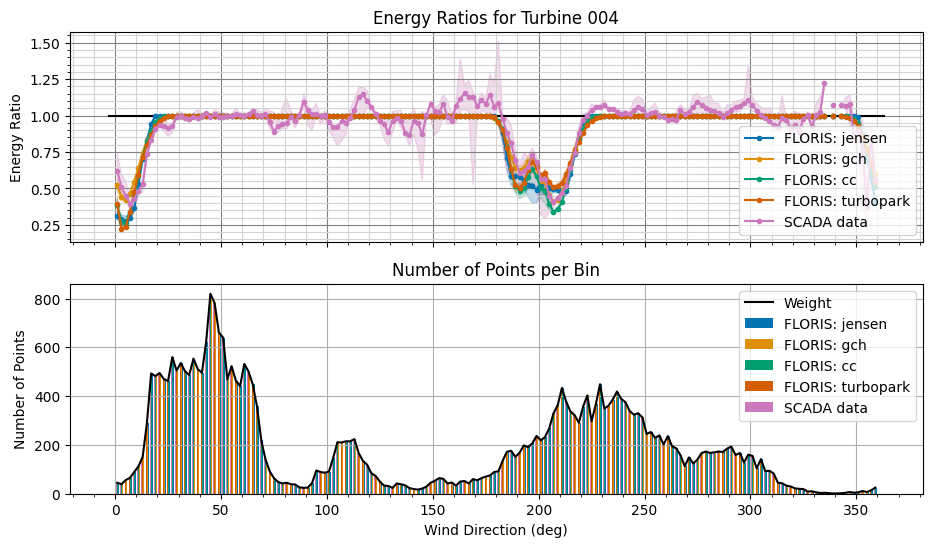

In [13]:
N = 20
print("Calculating energy ratios with bootstrapping (N={}).".format(N))
print("This may take a couple seconds...")
np.random.seed(0)
er_out = er.compute_energy_ratio(
    er_in,
    test_turbines=[4],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_bin_overlap_radius=0.0,
    ws_min=6.0,
    ws_max=12.0,
    N=N,
    percentiles=[5.0, 95.0],
)
ax = er_out.plot_energy_ratios(overlay_frequency=True)
ax[0].set_title("Energy Ratios for Turbine 004")

As shown in the plot above, overall there is good agreement between the SCADA-based energy ratio curve and the energy ratio predictions based on FLORIS results. However, because of relatively little data for many wind directions, the SCADA-based energy ratios are noisy and can deviate from the expected value of 1 when Turbine 004 is unwaked.

# Step 4: Rerun the energy ratio calculation with a different wind speed/wind direction distribution

As an example, we'll create a distribution with uniform frequency across 
all wind speds of interest and concentrated in the direction where SMV6 wakes SMV5.

Can also be used to evaluate the energy ratios under long-term site conditions.

Calculating energy ratios with bootstrapping (N=20).
This may take a couple seconds...


Text(0.5, 1.0, 'Energy Ratios for Turbine 004')

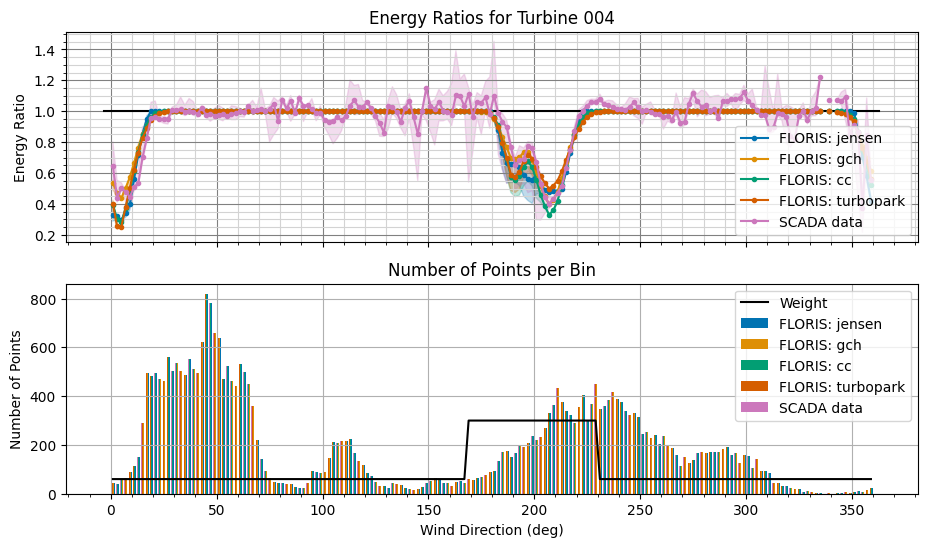

In [14]:
ws = np.tile(np.arange(6.5, 12.0, 1.0), 180)
wd = np.repeat(np.arange(1.0, 360.0, 2.0), 6)

freq = np.ones_like(ws)
# Increase frequency value in steering wind directions
start_idx = np.where(wd == 169)[0][0]
end_idx = np.where(wd == 231)[0][0]
freq[start_idx:end_idx] = 5
freq = 10 * freq

df_freq = pd.DataFrame({"ws": ws, "wd": wd, "freq_val": freq})

N = 20
print("Calculating energy ratios with bootstrapping (N={}).".format(N))
print("This may take a couple seconds...")
np.random.seed(0)
er_out = er.compute_energy_ratio(
    er_in,
    test_turbines=[4],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_bin_overlap_radius=0.0,
    ws_min=6.0,
    ws_max=12.0,
    df_freq=df_freq,
    N=N,
    percentiles=[5.0, 95.0],
)
ax = er_out.plot_energy_ratios(overlay_frequency=True)
ax[0].set_title("Energy Ratios for Turbine 004")